### Introduction

**What are Medial Lines?** 📐
A medial line (also known as a skeleton or medial axis) is a line that runs down the "middle" of a shape. Imagine a fire starting at every point on the boundary of a shape and burning inward at the same speed. The medial line is the set of points where the fire from different parts of the boundary meets. It perfectly represents the central core of a shape and is equidistant from the shape's boundaries at all points.

How Medial Lines are Useful in Histology? 🔬
Medial lines are a powerful tool for measuring and characterizing the extent and morphology of complex shapes in histology. They can be used to:

**Measure Tumor Extent:** Medial lines provide a precise way to calculate the length or span of irregularly shaped tumors or other tissue structures. Unlike simple bounding boxes, a medial line follows the true contours of the object, giving a more accurate measure of its longitudinal extent.

**Analyze Tumor Invasive Margins:** The length of the medial line at the interface between a tumor and healthy tissue can be used to quantify the extent of the invasive margin. A longer, more complex medial line at this boundary could indicate a more aggressive, invasive tumor with a convoluted growth pattern.

**Characterize Morphological Features:** Medial lines can also be used to simplify the shape of convoluted structures, allowing for the calculation of features like tortuosity or branching complexity. This helps in objectively describing features that are difficult to quantify with standard metrics.

In this tutorial, we will explore the concept of medial lines in more detail and demonstrate their application in histological analysis. We will use the cervix biopsy dataset as our example data.

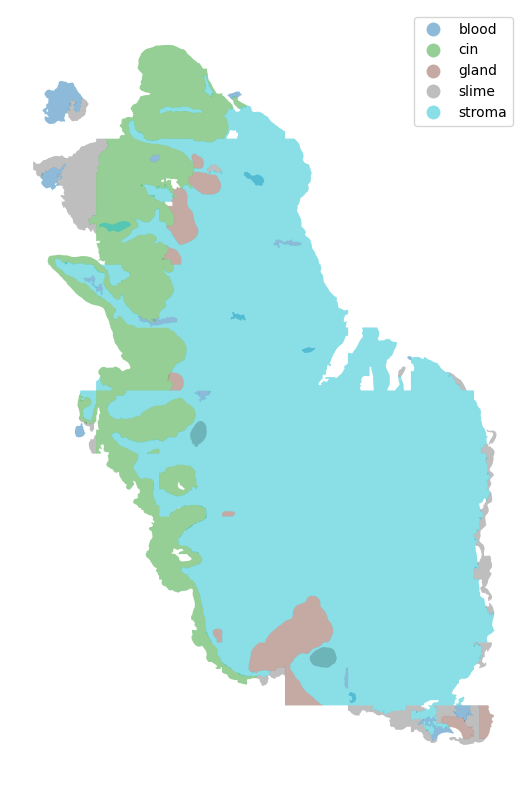

In [1]:
import matplotlib.pyplot as plt
from histolytics.data import cervix_tissue

tis = cervix_tissue()

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
ax.set_axis_off()

### Computing Medial Line

Next, we'll compute the medial lines with the `medial_lines` function for the CIN lesion segmentation geometries.
Parameters that should be taken into consideration when computing the medial lines include the simplification level and the number of points used for resampling the input polygons. The more there are points and the lower the simplification level, the more accurate the medial line will be, but this also increases computation time. Also, in some cases when there are too many resampled points, the resulting medial lines can be overly complex which results in breaks in lines that should be contiguous. You should play around with these parameters to find the best trade-off between accuracy and performance for your specific use case.

,geometry,class_name
5,"MULTILINESTRING ((3389.66038 10157.23114, 3389...",medial
6,"MULTILINESTRING ((2001.05171 4628.92169, 2000....",medial
46,"MULTILINESTRING ((3399.78589 1054.58574, 3341....",medial
48,"MULTILINESTRING ((2002.72995 4066.36095, 2008....",medial


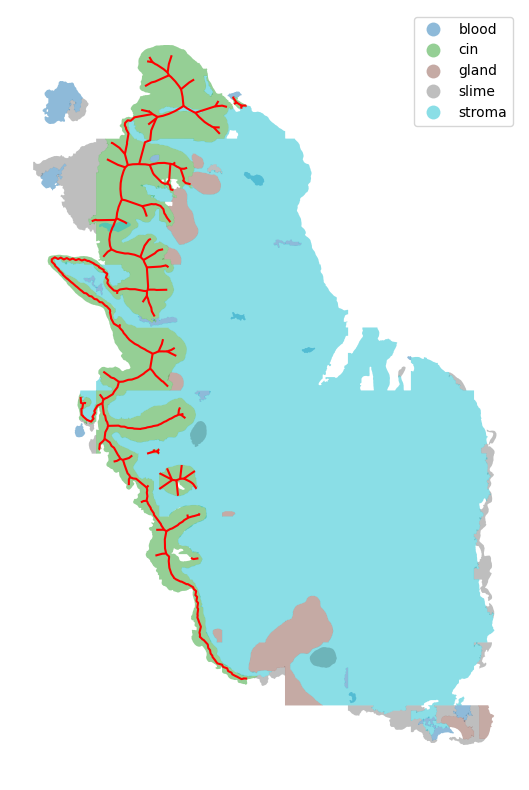

In [2]:
from histolytics.spatial_geom.medial_lines import medial_lines

cin = tis[tis["class_name"] == "cin"]
cin_medial = medial_lines(
    cin, num_points=500, simplify_level=50, parallel=True, num_processes=4
)

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
cin_medial.plot(ax=ax, color="red", aspect=1)
ax.set_axis_off()
cin_medial

Medial line differs from the length property of the input polygons in that it represents the central axis of the polygons, rather than its overall perimeter length. For example, in cervical lesion biopsies, the lesions can be very elongated and irregularly shaped, making the medial line length more robust measure of the lesion's extent.

In [3]:
cin_medial.length, cin.length

(5       379.700473
 6       294.584983
 46    32548.994078
 48     1811.082166
 dtype: float64,
 5       746.623794
 6       488.193192
 46    56703.570434
 48     2334.443902
 dtype: float64)

### Line Metrics of the Medial Line

Similar to the stromal collagen features that were extracted in a previous [tutorial](https://hautaniemilab.github.io/histolytics/user_guide/spatial/stromal_features/#collagen-features) , we can compute various line metrics for the medial line, such as tortuosity, average turning angle orientation. These measures can help quantify the complexity and shape of the lesion.

,geometry,class_name,length,tortuosity,average_turning_angle
5,"MULTILINESTRING ((3389.66038 10157.23114, 3389...",medial,379.700473,1.452964,2.777942
6,"MULTILINESTRING ((2001.05171 4628.92169, 2000....",medial,294.584983,1.434600,1.856054
46,"MULTILINESTRING ((3399.78589 1054.58574, 3341....",medial,32548.994078,4.449887,29.848962
48,"MULTILINESTRING ((2002.72995 4066.36095, 2008....",medial,1811.082166,3.058787,2.799758


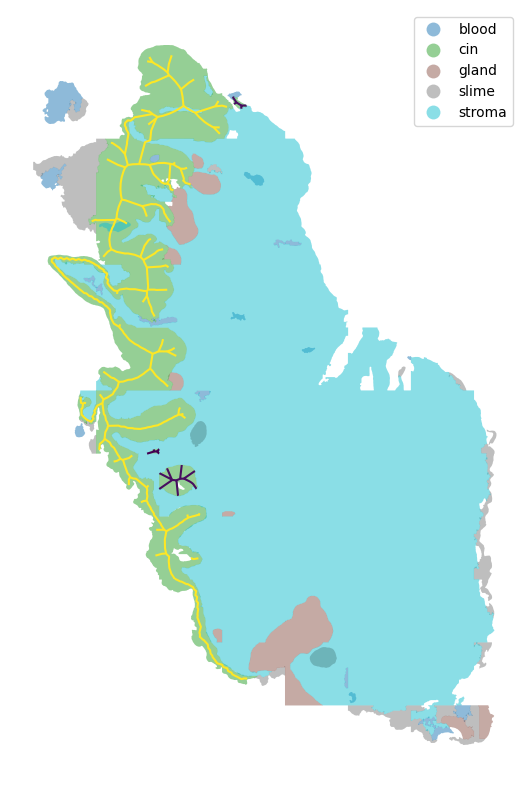

In [4]:
from histolytics.spatial_geom.line_metrics import line_metric

metrics = ["length", "tortuosity", "average_turning_angle"]

cin_medial = line_metric(cin_medial, metrics=metrics, normalize=False)

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
cin_medial.plot(ax=ax, cmap="viridis", column="average_turning_angle")
ax.set_axis_off()
cin_medial

### Length of Tumor Invasive Margin

Although the tumor invasive margin (IM) is not a concept in cervical lesions, it is an important factor in other types of cancers. The invasive margin often refers to the area at the edge of a tumor and stromal tissue. We'll showcase with the cervical lesion dataset, how the length of the IM would be computed using the `medial_lines` function and `get_interfaces` function that was introduced earlier in the [partitioning](https://hautaniemilab.github.io/histolytics/user_guide/spatial/partitioning/#tissue-interfaces) tutorial.

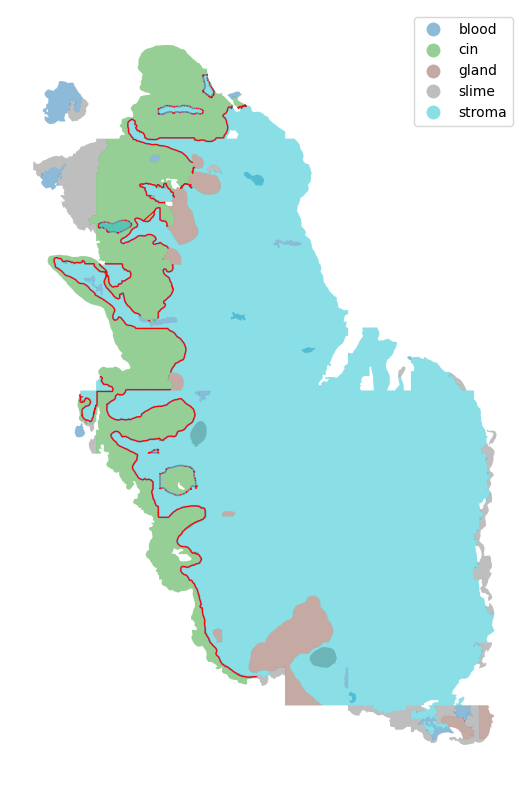

In [5]:
from histolytics.spatial_ops.ops import get_interfaces

stroma = tis[tis["class_name"] == "stroma"]
invasive_margin = get_interfaces(stroma, cin, buffer_dist=25, symmetric_buffer=False)
im_medial = medial_lines(invasive_margin, simplify_level=1, num_points=1000)

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=True)
ax = invasive_margin.plot(ax=ax, color="blue", lw=1, alpha=0.3)
ax = im_medial.plot(ax=ax, color="red", aspect=1, lw=0.8)
ax.set_axis_off()

The medial line algorithm is best suited for long contiguous polygons as it may fail for circular connected polygons as seen in the example above. If this happens, and you just need the length of the medial line, often the get_interfaces result polygons can be used as a proxy when a small enough buffer_dist is applied. The length of the and the length of the perimeter of such polygons are heavily correlated.

If you're satisfied with the resulting medial lines of your IM, you can use them for further line analysis as showcased in the previous example but we'll leave that for another time.

In [10]:
import numpy as np

# check correlation of medial line and invasive margin lengths
im_medial.length, invasive_margin.length
np.corrcoef(im_medial.length, invasive_margin.length)

array([[1.        , 0.98946081],
       [0.98946081, 1.        ]])

### Benchmark

The run-times of medial line computations depend on the input parameters such as the number of resampled points in the input polygons and the simplification level applied. Higher numbers of points and lower simplification levels will generally lead to longer computation times. However, in general, the run-times are quite reasonable and should not pose a significant bottleneck in most applications:

In [7]:
%%timeit
medial_lines(invasive_margin, simplify_level=1, num_points=1000)

718 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
medial_lines(invasive_margin, simplify_level=50, num_points=1000)

252 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
medial_lines(invasive_margin, simplify_level=50, num_points=500)

135 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
